<a href="https://colab.research.google.com/github/DanielAcostaRoa/NLP-BOW/blob/master/NLP_Twets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas.util.testing as tm
from collections import Counter
import numpy as np
import seaborn as sns
import nltk
import os
import re
from nltk.corpus.reader import CategorizedPlaintextCorpusReader as CPCR
from nltk.tokenize import TweetTokenizer
import csv
import argparse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score
from sklearn import metrics, preprocessing
import numpy as np
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
def get_texts_from_file(path_corpus, path_truth):
    tr_txt = []
    tr_y = []
    with open(path_corpus, "r") as f_corpus, open(path_truth, "r") as f_truth:
        for twitt in f_corpus:
            tr_txt += [twitt.lower()]
        for label in f_truth:
            tr_y += [label]        
    return tr_txt, tr_y

In [ ]:
tuit_tr, label_tuit_tr = get_texts_from_file("./mex20_train.txt", "./mex20_train_labels.txt")
tuit_val, label_tuit_val = get_texts_from_file("./mex20_val.txt", "./mex20_val_labels.txt")

label_tuit_tr = list(map(int, label_tuit_tr))
label_tuit_val = list(map(int, label_tuit_val))

Counter({0: 3759, 1: 1519})


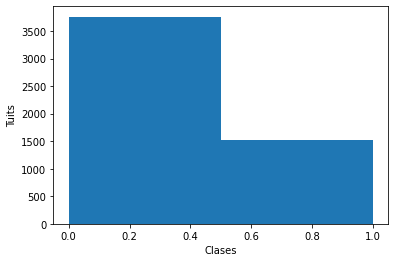

In [ ]:
print(Counter(label_tuit_tr))
plt.hist(label_tuit_tr, bins=len(set(label_tuit_tr)))
plt.ylabel('Tuits');
plt.xlabel('Clases');

In [ ]:
tokens = []
tt = []
tk2 = TweetTokenizer(reduce_len=True)
for i in tuit_tr:
  tok = tk2.tokenize(i)
  tt.append(tok)
  for j in tok:
    tokens.append(j)

In [ ]:
tt

[['@usuario',
  '@usuario',
  '@usuario',
  'q',
  'se',
  'puede',
  'esperar',
  'del',
  'maricon',
  'de',
  'closet',
  'de',
  'la',
  'yañez',
  'aun',
  'recuerdo',
  'esa',
  'ves',
  'q',
  'lo',
  'vi',
  'en',
  'zona',
  'rosa',
  'viendo',
  'quien',
  'lo',
  'levantada'],
 ['@usuario',
  'la',
  'piel',
  'nueva',
  'siempre',
  'arde',
  'un',
  'poquito',
  'los',
  'primeros',
  'días',
  '...',
  'y',
  'más',
  'con',
  'este',
  'puto',
  'clima'],
 ['ustedes', 'no', 'se', 'enamoran', 'de', 'mí', '…', 'por', 'tontas', '.'],
 ['me',
  'las',
  'va',
  'a',
  'pagar',
  'esa',
  'puta',
  'gorda',
  'roba',
  'tuits',
  '...'],
 ['@usuario',
  'la',
  'gente',
  'es',
  'tonta',
  'porque',
  'no',
  'se',
  'dan',
  'cuenta',
  'que',
  'tú',
  'haces',
  'a',
  'batman',
  'azul'],
 ['estoy',
  'muy',
  'encabronada',
  'con',
  'las',
  'pseudo',
  'feministas',
  'por',
  'tontas',
  'e',
  'iletradas',
  ',',
  'a',
  'veces',
  'me',
  'avergüenza',
  'ser',
 

In [ ]:
fdist = nltk.FreqDist(tokens)

In [ ]:
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [ ]:
V = sortFreqDict(fdist)
V = V[:10000]

In [ ]:
dict_indices = dict()
cont = 0
for weight, word in V:
    dict_indices[word] = cont
    cont += 1   

In [ ]:
def build_bow_tfidf(tr_txt, V, dict_indices):
    tf = np.zeros((len(tr_txt),len(V)), dtype=float)
    cont_doc = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tk2.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices:
                tf[cont_doc, dict_indices[word]] = fdist_doc[word]
        cont_doc += 1
    idf = np.ones((len(V)))
    for weight, word in V:
      for tr in tr_txt:
        if word in tr:
          idf[dict_indices[word]] +=1
    idf = np.log2( len(tr_txt)/idf ) + 1
    for i in range(len(tr_txt)):
      tf[i] = tf[i]*idf
      norma = np.linalg.norm(tf[i])
      if norma != 0:
        tf[i] = tf[i] / norma
    return tf

In [ ]:
def build_bow_bin(tr_txt, V, dict_indices):
    BOW = np.zeros((len(tr_txt),len(V)), dtype=float)
    cont_doc = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tk2.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices:
                BOW[cont_doc, dict_indices[word]] = 1
        cont_doc += 1
    return BOW

In [ ]:
BOW_tfidf_tr = build_bow_tfidf(tuit_tr, V, dict_indices)
BOW_tfidf_val = build_bow_tfidf(tuit_val, V, dict_indices)

In [ ]:
u, s, v = np.linalg.svd(BOW_tfidf_tr.T, full_matrices=True)

In [ ]:
r = 1000
s_inv = np.diag(1.0/s[0:r])
BOW_svd_tr = np.dot(np.dot(s_inv,u[:,0:r].T),BOW_tfidf_tr.T).T
BOW_svd_val = np.dot(np.dot(s_inv,u[:,0:r].T),BOW_tfidf_val.T).T

In [ ]:
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}
svr = svm.LinearSVC(class_weight='balanced')
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="f1_macro", cv=5)
grid.fit(BOW_svd_tr, label_tuit_tr) 
y_pred = grid.predict(BOW_svd_val)
p, r, f, _ = precision_recall_fscore_support(label_tuit_val, y_pred, average='macro', pos_label=None)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print(confusion_matrix(label_tuit_val, y_pred))
print(metrics.classification_report(label_tuit_val, y_pred))

[[364  54]
 [ 41 128]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       418
           1       0.70      0.76      0.73       169

    accuracy                           0.84       587
   macro avg       0.80      0.81      0.81       587
weighted avg       0.84      0.84      0.84       587



In [ ]:
def informacion_mutua(textos, labels, V, dict_indices):
  np_c0 = Counter(labels)[0]+1  #numero de documentos de clase 0
  np_c1 = Counter(labels)[1]+1 #numero de documentos de clase 1
  np_d = np.ones((len(V))) + 1      #numero de documentos donde aparece la palabra i
  np_d_c0 = np.ones((len(V)))    #numero de documentos de la clase 0 donde aparece la palabra i
  np_d_c1 = np.ones((len(V)))    #numero de documentos de la clase 1 donde aparece la palabra i
  ii=0
  tam=len(labels)+2
  for weight, word in V: #Para cada palabra en BoW
    cont=0
    for tuit in textos:  #Para cada tuit
      if word in tuit:   #si la palabra aparece en el tuit
        if labels[cont] == 0: #contamos si es clase 0
          np_d_c0[ii]+=1
        else:                 #contamos si es clase 1
          np_d_c1[ii]+=1
        np_d[ii]+=1 #contamos
      cont+=1
    ii+=1
  np_d_c0 = np_d_c0/tam #calculamos probabilidades
  np_d_c1 = np_d_c1/tam
  np_d = np_d/tam
  np_c0=np_c0/tam
  np_c1=np_c1/tam
  info0 = np.log2( np_d_c0 / (np_c0* np_d ) ) #calculamos informacion
  info1 = np.log2( np_d_c1 / (np_c1* np_d ) )
  infoT = np_c0*info0 + np_c1*info1
  return infoT, info0, info1

In [ ]:
info, info0, info1= informacion_mutua(tt,label_tuit_tr ,V, dict_indices)

In [ ]:
arg0 = np.flip(np.argsort(info0))
arg1 = np.flip(np.argsort(info1))

In [ ]:
V0 = []
V1 = []
for i in range(len(V)):
  V0.append(V[arg0[i]][1])
  V1.append(V[arg1[i]][1])
vv = list(set(V0[0:100]+V1[0:100]))
V_1=[]
for j, i in V:
  if i in vv:
    V_1.append((j,i))
dict_indices_1 = dict()
cont = 0
for weight, word in V_1:
    dict_indices_1[word] = cont
    cont += 1   

In [ ]:
BOW_bin1_tr = build_bow_bin(tuit_tr, V_1, dict_indices_1)
BOW_bin1_val = build_bow_bin(tuit_val, V_1, dict_indices_1)

In [ ]:
u1, s1, v1 = np.linalg.svd(BOW_bin1_tr.T, full_matrices=True)

In [ ]:
r = 10
s_inv = np.diag(1.0/s1[0:r])
BOW_svdB_tr = np.dot(np.dot(s_inv,u1[:,0:r].T),BOW_bin1_tr.T).T
BOW_svdB_val = np.dot(np.dot(s_inv,u1[:,0:r].T),BOW_bin1_val.T).T

In [ ]:
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}
svr = svm.LinearSVC(class_weight='balanced')
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="f1_macro", cv=5)
grid.fit(BOW_svdB_tr, label_tuit_tr) 
y_pred = grid.predict(BOW_svdB_val)
p, r, f, _ = precision_recall_fscore_support(label_tuit_val, y_pred, average='macro', pos_label=None)

In [ ]:
print(confusion_matrix(label_tuit_val, y_pred))
print(metrics.classification_report(label_tuit_val, y_pred))

[[403  15]
 [118  51]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86       418
           1       0.77      0.30      0.43       169

    accuracy                           0.77       587
   macro avg       0.77      0.63      0.65       587
weighted avg       0.77      0.77      0.74       587



In [ ]:
V0 = []
V1 = []
for i in range(len(V)):
  V0.append(V[arg0[i]][1])
  V1.append(V[arg1[i]][1])
vv = list(set(V1[0:50]))
V_0=[]
for j, i in V:
  if i in vv:
    V_0.append((j,i))
dict_indices_0 = dict()
cont = 0
for weight, word in V_2:
    dict_indices_0[word] = cont
    cont += 1   

In [ ]:
BOW_bin0_tr = build_bow_bin(tuit_tr, V_0, dict_indices_0)
BOW_bin0_val = build_bow_bin(tuit_val, V_0, dict_indices_0)

In [ ]:
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}
svr = svm.LinearSVC(class_weight='balanced')
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="f1_macro", cv=5)
grid.fit(BOW_bin0_tr, label_tuit_tr) 
y_pred = grid.predict(BOW_bin0_val)
p, r, f, _ = precision_recall_fscore_support(label_tuit_val, y_pred, average='macro', pos_label=None)

In [ ]:
print(confusion_matrix(label_tuit_val, y_pred))
print(metrics.classification_report(label_tuit_val, y_pred))

[[405  13]
 [114  55]]
              precision    recall  f1-score   support

           0       0.78      0.97      0.86       418
           1       0.81      0.33      0.46       169

    accuracy                           0.78       587
   macro avg       0.79      0.65      0.66       587
weighted avg       0.79      0.78      0.75       587

